In [1]:
import numpy as np
import pandas as pd
from toolz import curry
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import cvxpy as cp

import toolz as f

from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

from matplotlib import style
style.use("ggplot")

In [2]:
data = pd.read_csv("data/smoking.csv")

data = data.pivot("year", "state", "cigsale")
data = data.rename(columns={c: f"state_{c}" for c in data.columns}).rename(columns={"state_3": "california"})

data = data[[c for c in data.columns if "state_" in c] + ["california"]] # place california last
data.head()

state,state_1,state_2,state_4,state_5,state_6,state_7,state_8,state_9,state_10,state_11,...,state_31,state_32,state_33,state_34,state_35,state_36,state_37,state_38,state_39,california
year,,,,,,,,,,,,,,,,,,,,,
1970,89.800003,100.300003,124.800003,120.000000,155.000000,109.900002,102.400002,124.800003,134.600006,108.500000,...,92.699997,99.800003,106.400002,65.500000,122.599998,124.300003,114.500000,106.400002,132.199997,123.000000
1971,95.400002,104.099998,125.500000,117.599998,161.100006,115.699997,108.500000,125.599998,139.300003,108.400002,...,96.699997,106.300003,108.900002,67.699997,124.400002,128.399994,111.500000,105.400002,131.699997,121.000000
1972,101.099998,103.900002,134.300003,110.800003,156.300003,117.000000,126.099998,126.599998,149.199997,109.400002,...,103.000000,111.500000,108.599998,71.300003,138.000000,137.000000,117.500000,108.800003,140.000000,123.500000
1973,102.900002,108.000000,137.899994,109.300003,154.699997,119.800003,121.800003,124.400002,156.000000,110.599998,...,103.500000,109.699997,110.400002,72.699997,146.800003,143.100006,116.599998,109.500000,141.199997,124.400002
1974,108.199997,109.699997,132.800003,112.400002,151.300003,123.699997,125.599998,131.899994,159.600006,116.099998,...,108.400002,114.800003,114.699997,75.599998,151.800003,149.600006,119.900002,111.800003,145.800003,126.699997


Text(0, 0.5, 'Cigarette Sales')

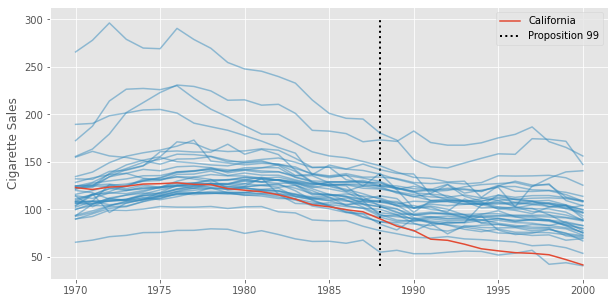

In [3]:
plt.figure(figsize=(10,5))
plt.plot(data.drop(columns=["california"]), color="C1", alpha=0.5)
plt.plot(data["california"], color="C0", label="California")
plt.vlines(x=1988, ymin=40, ymax=300, linestyle=":", lw=2, label="Proposition 99", color="black")
plt.legend()
plt.ylabel("Cigarette Sales")

In [4]:
def calculate_regularization(X, n_treat, n_post):
        return (n_treat*n_post)**(1/4) * (X[1:, :] - X[:-1, :]).std()

    
def fit_unit_weights(X_pre, y_pre_mean, n_treat, n_post):
        T_pre = X_pre.shape[0]
        zeta = calculate_regularization(X_pre, n_treat, n_post)
        
        X = np.concatenate([np.ones((T_pre, 1)), X_pre], axis=1) # add intercept
        
        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y_pre_mean) + T_pre*zeta**2 * cp.sum_squares(w[1:]))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        return w.value[1:] # remove intercept

In [5]:
X_pre_control = data[data.index < 1989].drop(columns="california")
y_pre_treated = data[data.index < 1989]["california"]

n_treated = 1

unit_weights = fit_unit_weights(X_pre_control.values, y_pre_treated.values, n_treat=n_treated, n_post=data.shape[0] - X_pre_control.shape[0])
unit_weights = pd.Series(unit_weights, index=X_pre_control.columns)

unit_weights.round(3)

state
state_1    -0.000
state_2    -0.000
state_4     0.057
state_5     0.078
state_6     0.070
state_7     0.002
state_8     0.032
state_9     0.053
state_10    0.010
state_11    0.026
state_12    0.022
state_13   -0.000
state_14   -0.000
state_15    0.028
state_16    0.040
state_17   -0.000
state_18    0.008
state_19    0.045
state_20    0.048
state_21    0.124
state_22    0.105
state_23    0.041
state_24    0.033
state_25   -0.000
state_26    0.032
state_27   -0.000
state_28    0.016
state_29    0.001
state_30   -0.000
state_31    0.004
state_32   -0.000
state_33    0.010
state_34    0.042
state_35   -0.000
state_36   -0.000
state_37    0.034
state_38    0.037
state_39    0.001
dtype: float64

In [6]:
def fit_time_weights(X_pre, y_post_mean):
        
        X = np.concatenate([np.ones((X_pre.shape[0], 1)), X_pre], axis=1) # add intercept

        w = cp.Variable(X.shape[1])
        objective = cp.Minimize(cp.sum_squares(X@w - y_post_mean))
        constraints = [cp.sum(w[1:]) == 1, w[1:] >= 0]
        
        problem = cp.Problem(objective, constraints)
        problem.solve(verbose=False)
        
        return w.value[1:] # remove intercept

In [7]:
X_pre = data[data.index < 1989].drop(columns="california").T
y_post = data[data.index >= 1989].drop(columns="california").T.mean(axis=1)

time_weights = pd.Series(fit_time_weights(X_pre.values, y_post.values), index=X_pre.columns)

time_weights.round(3)

year
1970   -0.000
1971   -0.000
1972   -0.000
1973   -0.000
1974   -0.000
1975   -0.000
1976   -0.000
1977   -0.000
1978   -0.000
1979   -0.000
1980   -0.000
1981   -0.000
1982   -0.000
1983   -0.000
1984   -0.000
1985   -0.000
1986    0.366
1987    0.206
1988    0.427
dtype: float64

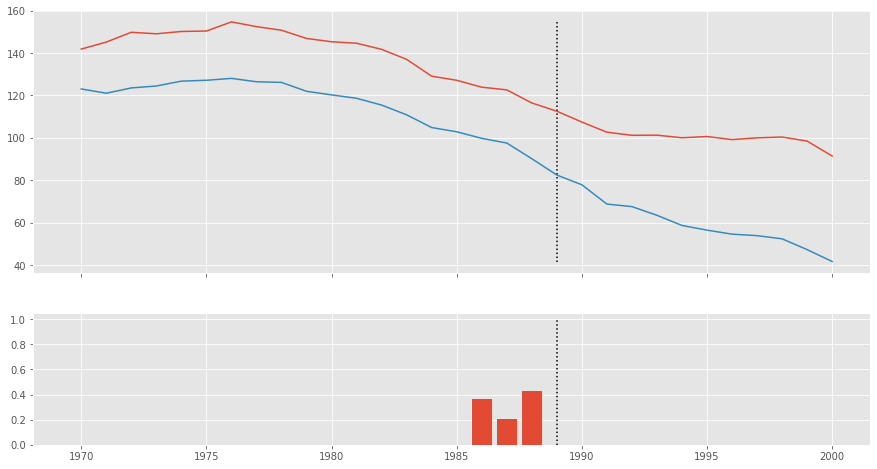

In [8]:
sc = data.drop(columns="california").values @ unit_weights.values

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

ax1.plot(data.index, sc)
ax1.plot(data.index, data["california"])
ax1.vlines(1989, data["california"].min(), sc.max(), color="black", ls="dotted")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")

In [9]:
pre_sc = (sc[0:len(time_weights)] * time_weights).sum()
post_sc = sc[len(time_weights):].mean()

pre_treat = (data["california"].iloc[0:len(time_weights)] * time_weights).sum()
post_treat = data["california"].iloc[len(time_weights):].mean()

In [10]:
sc_did_y0 = pre_treat + (post_sc - pre_sc)
sc_did_att = (post_sc - pre_sc) - (post_treat - pre_treat)
sc_did_att

15.604230923237232

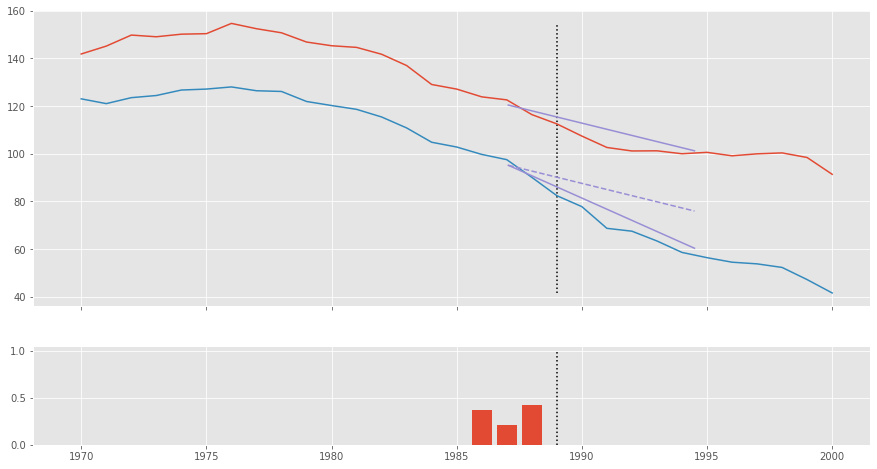

In [11]:
sc = data.drop(columns="california").values @ unit_weights.values
avg_pre_period = (time_weights * time_weights.index).sum()
avg_post_period = 1989 + (2000 - 1989) / 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(data.index, sc)
ax1.plot(data.index, data["california"])
ax1.vlines(1989, data["california"].min(), sc.max(), color="black", ls="dotted")

ax1.plot([avg_pre_period, avg_post_period], [pre_sc, post_sc], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, post_treat], color="C2")
ax1.plot([avg_pre_period, avg_post_period], [pre_treat, sc_did_y0], color="C2", ls="dashed")

ax2.bar(time_weights.index, time_weights)
ax2.vlines(1989, 0, 1, color="black", ls="dotted")

In [12]:
did_data = (
    data
    .melt(ignore_index=False)
    .join(time_weights.rename("time_w"))
    .reset_index()
    .set_index("state")
    .join(unit_weights.rename("unit_w"))
    .reset_index()
    .fillna({"time_w": 1/(data.shape[0] - len(time_weights)),
             "unit_w": 1/(data.shape[1] - len(unit_weights))})
    .assign(w = lambda d: d["time_w"]*d["unit_w"])
    .assign(treated = lambda d: np.where((d["state"] == "california"), 1, 0))
    .assign(post = lambda d: np.where(d["year"] > 1988, 1, 0))
)

In [13]:
smf.wls("value ~ treated*post",
        data=did_data,
        weights=did_data["w"]+1e-10).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,120.4043,1.272,94.663,0.000,117.909,122.900
treated,-25.2584,1.799,-14.042,0.000,-28.788,-21.729
post,-19.1916,1.799,-10.669,0.000,-22.721,-15.663
treated:post,-15.6042,2.544,-6.134,0.000,-20.595,-10.613


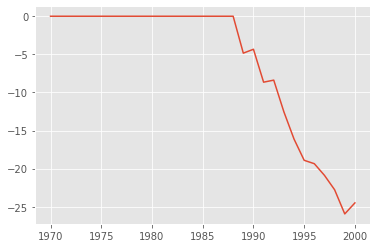

In [14]:
model = smf.wls("value ~ treated:post:C(year) + C(state) + C(year)",
        data=did_data,
        weights=did_data["w"] + 1e-10,
       ).fit()

effect = pd.Series(model.params[model.params.index.str.contains("treated")].values,
                   index=sorted(did_data["year"].unique()))
effect.plot();

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
from sklearn.linear_model import LinearRegression

class SyntheticDiD(BaseEstimator, TransformerMixin):

    def __init__(self, n_treat, n_post):

        self.n_treat = n_treat
        self.n_post = n_post

        
    def fit(self, X):

        X = check_array(X)
        
        n_post = self.n_post
        n_treat = self.n_treat
        
        X_pre_control = X[:-n_post, :-n_treat]
        X_pre_treated = X[:-n_post, -n_treat:]
        X_post_control = X[-n_post:, :-n_treat]
        
        # fit unit weights
        unit_weights_control = fit_unit_weights(X_pre_control, X_pre_treated.mean(axis=1), n_treat=n_treat, n_post=n_post)
        unit_weights_treat = 1/n_treated
        unit_weights = np.concatenate([unit_weights_control, np.repeat(unit_weights_treat, n_treated)])
        
        # fit time weights
        time_weights_pre = fit_time_weights(X_pre_control.T, X_post_control.T.mean(axis=1))
        time_weights_post = 1/n_post
        time_weights = np.concatenate([time_weights_pre, np.repeat(time_weights_post, n_post)])
        
        # Fit DiD
        X_melt = X.reshape(-1, 1)
        weight_melt = np.tile(unit_weights, X.shape[0]) * np.repeat(time_weights, X.shape[1])
        
        treated = np.tile(np.concatenate([np.zeros(X.shape[1]-n_treat), np.ones(n_treat)]), X.shape[0])
        post = np.repeat(np.concatenate([np.zeros(X.shape[0]-n_post), np.ones(n_post)]), X.shape[1])
        
        X_regr = np.column_stack([treated, post, treated*post])
        y_regr = X_melt
        
        coefs = LinearRegression().fit(X_regr, y_regr, sample_weight=weight_melt+1e-10).coef_
        
        # save model
        self.unit_weights_  = unit_weights
        self.time_weights_  = time_weights
        self.coef_ = coefs
        self.att_ = coefs[-1][-1]
        self.is_fitted_ = True
        return self
        
        
    def predict(self, X):
        check_is_fitted(self)
        X0 = check_array(X).copy()
        X0[-self.n_post:, -self.n_treat:] -= self.att_
        return X0

In [16]:
scdid = SyntheticDiD(n_treat=1, n_post=12)
scdid.fit(data)
scdid.att_

-15.60423026788148

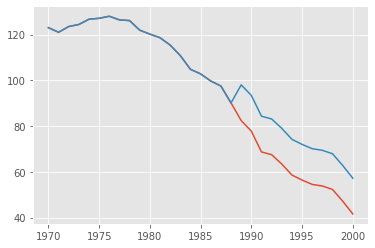

In [17]:
pred_df = pd.DataFrame(scdid.predict(data), columns=data.columns, index=data.index)

plt.plot(data["california"])
plt.plot(pred_df["california"]);